In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import interpolate

## Bộ dữ liệu kênh truyền

Mô hình kênh truyền vô tuyến được chọn là mô hình Vehicular-A, với:
- Tần số sóng mang 2.1 GHz
- Băng thông 1.6 MHz
- Tốc độ thiết bị người dùng là 50 km/h.

Mô hình kênh truyền bao gồm 3 bộ dữ liệu:
- Đáp ứng kênh truyền lý tưởng
- Đáp ứng kênh truyền nhiễu với SNR = 22
- Đáp ứng kênh truyền nhiễu với SNR = 12

Mỗi bộ dữ liệu có 40000 mẫu đáp ứng kênh trong miền thời gian - tần số, 
với 72 sóng mang con và 14 khe thời gian.

In [62]:
channel_model = "VehA"
n_subs = 72
n_slots = 14
snr = 12
n_pilots = 48
n_samples = 10000

In [63]:
# Mô hình kênh truyền lý tưởng
perfect = loadmat("data/Perfect_H_" + str(n_samples) + ".mat")['My_perfect_H']
# Mô hình kênh truyền nhiễu
noisy_input = loadmat("data/My_noisy_H_12_" + str(n_samples) + ".mat")["My_noisy_H"]

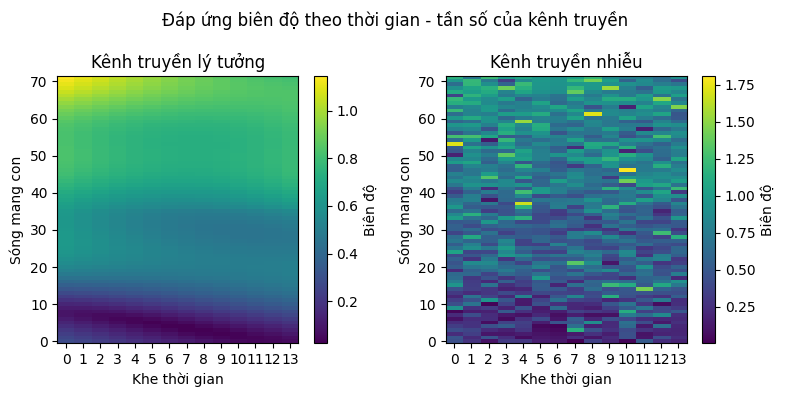

In [64]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
fig.suptitle('Đáp ứng biên độ theo thời gian - tần số của kênh truyền')

# Đáp ứng biên độ của kênh truyền lý tưởng
perfect_response = np.abs(perfect[0].squeeze())
# Đáp ứng biên độ của kênh truyền nhiễu
noisy_response = np.abs(noisy_input[0].squeeze())

# Vẽ đáp ứng
cax = axes[0].imshow(perfect_response, aspect='auto', origin='lower', interpolation='none')
fig.colorbar(cax, label='Biên độ')
axes[0].set_title('Kênh truyền lý tưởng')
cax = axes[1].imshow(noisy_response, aspect='auto', origin='lower', interpolation='none')
fig.colorbar(cax, label='Biên độ')
axes[1].set_title('Kênh truyền nhiễu')

for ax in axes:
    ax.set_ylabel('Sóng mang con')
    ax.set_xlabel('Khe thời gian')
    ax.set_xticks(np.arange(0, n_slots, step=1))
    ax.set_yticks(np.arange(0, n_subs, step=10))

plt.tight_layout()
plt.show()

## Cấu trúc sắp xếp pilot

Số lượng pilot ảnh hưởng đến dữ liệu nội suy kênh nhiễu, mà kênh nhiễu là ngõ vào của mô hình máy học. 

Do đó, ứng với số lượng pilot khác nhau, ta cũng có một tập dữ liệu huấn luyện và một mạng neuron tối ưu riêng.

Số lượng pilot được chọn tiêu biểu từ tập {8, 16, 24, 36, 48}

In [65]:
n_pilots

48

In [66]:
if n_pilots == 48:
    idx = [14 * i for i in range(1, 72, 6)] + [4 + 14 * i for i in range(4, 72, 6)] + \
            [7 + 14 * i for i in range(1, 72, 6)] + [11 + 14 * i for i in range(4, 72, 6)]
elif n_pilots == 16:
    idx = [4 + 14 * i for i in range(1, 72, 9)] + [9 + 14 * i for i in range(4, 72, 9)]
elif n_pilots == 24:
    idx = [14 * i for i in range(1, 72, 9)] + [6 + 14 * i for i in range(4, 72, 9)] + [11 + 14 * i for i in
                                                                                        range(1, 72, 9)]
elif n_pilots == 8:
    idx = [4 + 14 * i for i in range(5, 72, 18)] + [9 + 14 * i for i in range(8, 72, 18)]
elif n_pilots == 36:
    idx = [14 * i for i in range(1, 72, 6)] + [6 + 14 * i for i in range(4, 72, 6)] + [11 + 14 * i for i in
                                                                                        range(1, 72, 6)]
P = np.zeros(n_slots*n_subs)
for i in idx: P[i] = 5
P.reshape((n_slots, n_subs))
T, F = np.meshgrid(range(1, n_slots+1), range(1, n_subs+1))

r = [x // 14 for x in idx]
c = [x % 14 for x in idx]

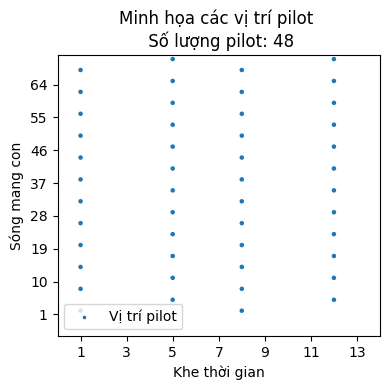

In [67]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(T, F, P, label='Vị trí pilot')
ax.legend()
ax.set_title("Minh họa các vị trí pilot \n Số lượng pilot: %d" % n_pilots)

ax.set_xlabel('Khe thời gian')
ax.set_ylabel('Sóng mang con')
ax.set_xlim(0, n_slots)
ax.set_ylim(-5, n_subs)
ax.set_xticks(range(1, n_slots, 2))
ax.set_yticks(range(1, n_subs, 9))

plt.tight_layout()
plt.show()

## Chuẩn bị dữ liệu cho huấn luyện

### 1. Nội suy kênh nhiễu từ pilot và Định dạng kênh nhiễu

In [68]:
noisy_image = np.zeros((n_samples, n_subs, n_slots, 2))

# Tách ảnh thành phần thực và phần ảo
noisy_image[:, :, :, 0] = np.real(noisy_input)
noisy_image[:, :, :, 1] = np.imag(noisy_input)

interp_noisy = np.zeros((n_samples, n_subs, n_slots, 2))

for i in range(len(noisy_input)):
    z = [noisy_image[i, j, k, 0] for j, k in zip(r, c)]
    f = interpolate.Rbf(np.array(r).astype(float), np.array(c).astype(float), z, function='gaussian')
    X, Y = np.meshgrid(range(n_subs), range(n_slots))
    z_intp = f(X, Y)
    interp_noisy[i, :, :, 0] = z_intp.T

    z = [noisy_image[i, j, k, 1] for j, k in zip(r, c)]
    f = interpolate.Rbf(np.array(r).astype(float), np.array(c).astype(float), z, function='gaussian')
    X, Y = np.meshgrid(range(n_subs), range(n_slots))
    z_intp = f(X, Y)
    interp_noisy[i, :, :, 1] = z_intp.T

interp_noisy = np.concatenate((interp_noisy[:, :, :, 0], 
                               interp_noisy[:, :, :, 1]), axis=0).reshape(2*n_samples, n_subs, n_slots, 1)

### 2. Định dạng dữ liệu kênh lý tưởng

In [69]:
perfect_image = np.zeros((n_samples, n_subs, n_slots, 2))
perfect_image[:, :, :, 0] = np.real(perfect)
perfect_image[:, :, :, 1] = np.imag(perfect)
perfect_image = np.concatenate((perfect_image[:, :, :, 0], 
                                perfect_image[:, :, :, 1]), axis=0)
perfect_image = perfect_image.reshape(2*n_samples, n_subs, n_slots, 1)

In [18]:
path = "data/images_" + channel_model \
    + "_" + str(n_pilots) \
    + "_" + str(snr) \
    + "_" + str(n_samples) + ".mat"
savemat(path, {'interp_noisy': interp_noisy, 'perfect_image': perfect_image})

### 3. Chia tập huấn luyện và kiểm tra

In [20]:
channel_model = "VehA"
n_pilots = 48
snr = 12
n_samples = 10000

path = "data/images_" + channel_model \
    + "_" + str(n_pilots) \
    + "_" + str(snr) \
    + "_" + str(n_samples) + ".mat"
interp_noisy = loadmat(path)['interp_noisy']
perfect_image = loadmat(path)['perfect_image']

In [71]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_label, val_label = \
    train_test_split(interp_noisy, perfect_image, test_size=0.2)

In [72]:
print(train_data.shape)
print(train_label.shape)
print(val_data.shape)
print(val_label.shape)

(16000, 72, 14, 1)
(16000, 72, 14, 1)
(4000, 72, 14, 1)
(4000, 72, 14, 1)


## Huấn luyện

Huấn luyện mô hình với tập dữ liệu huấn luyện đã chuẩn bị, với:
- Mô hình kênh truyền Vehicular-A
- Số lượng pilot thuộc tập {8, 16, 24, 36, 48}
- SNR = 12 dB

In [74]:
import models, importlib
importlib.reload(models)

models.SRCNN_train(train_data, train_label, val_data, val_label, channel_model, n_pilots, snr, n_samples)

Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)     │ (None, 72, 14, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_138 (Conv2D)             │ (None, 72, 14, 64)     │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 72, 14, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_140 (Conv2D)             │ (None, 72, 14, 1)      │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1: val_loss improved from inf to 0.01435, saving model to trained_nets/SRCNN_check.keras

Epoch 2: val_loss improved from 0.01435 to 0.01176, saving model to trained_nets/SRCNN_check.keras

Epoch 3: val_loss improved from 0.01176 to 0.01066, saving model to trained_nets/SRCNN_check.keras

Epoch 4: val_loss improved from 0.01066 to 0.01004, saving model to trained_nets/SRCNN_check.keras

Epoch 5: val_loss improved from 0.01004 to 0.00960, saving model to trained_nets/SRCNN_check.keras

Epoch 6: val_loss improved from 0.00960 to 0.00938, saving model to trained_nets/SRCNN_check.keras

Epoch 7: val_loss improved from 0.00938 to 0.00923, saving model to trained_nets/SRCNN_check.keras

Epoch 8: val_loss improved from 0.00923 to 0.00885, saving model to trained_nets/SRCNN_check.keras

Epoch 9: val_loss did not improve from 0.00885

Epoch 10: val_loss improved from 0.00885 to 0.00862, saving model to trained_nets/SRCNN_check.keras


## Kiểm tra mô hình

In [76]:
import models, importlib
importlib.reload(models)

# Từ mô hình đã huấn luyện, ước lượng kênh truyền của tập dữ liệu kiểm tra
srcnn_pred_validation = models.SRCNN_predict(val_data, channel_model, n_pilots, snr, n_samples)

  1/125 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step

c:\Users\Khanh\miniconda3\envs\tf\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


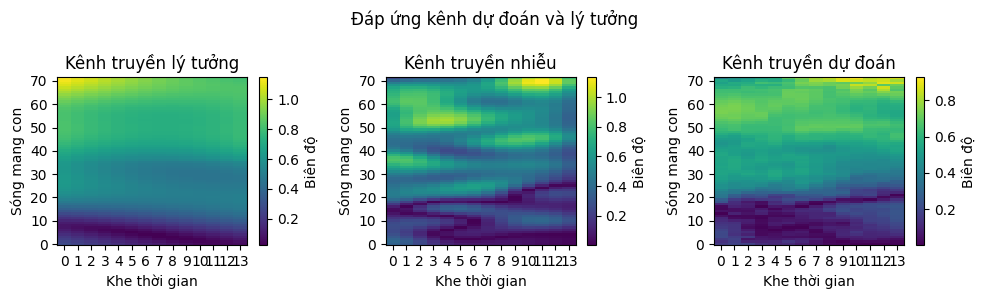

In [77]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(10, 3)
fig.suptitle('Đáp ứng kênh dự đoán và lý tưởng')

# Đáp ứng biên độ của kênh truyền lý tưởng
perfect_response = np.abs(perfect[0].squeeze())
# Đáp ứng biên độ của kênh truyền nhiễu
noisy_response = np.abs(val_data[0].squeeze())
# Đáp ứng biên độ của kênh truyền dự đoán
pred_response = np.abs(srcnn_pred_validation[0].squeeze())

# Vẽ đáp ứng
cax = axes[0].imshow(perfect_response, aspect='auto', origin='lower', interpolation='none')
fig.colorbar(cax, label='Biên độ')
axes[0].set_title('Kênh truyền lý tưởng')
cax = axes[1].imshow(noisy_response, aspect='auto', origin='lower', interpolation='none')
fig.colorbar(cax, label='Biên độ')
axes[1].set_title('Kênh truyền nhiễu')
cax = axes[2].imshow(pred_response, aspect='auto', origin='lower', interpolation='none')
fig.colorbar(cax, label='Biên độ')
axes[2].set_title('Kênh truyền dự đoán')

for ax in axes:
    ax.set_ylabel('Sóng mang con')
    ax.set_xlabel('Khe thời gian')
    ax.set_xticks(np.arange(0, n_slots, step=1))
    ax.set_yticks(np.arange(0, n_subs, step=10))

plt.tight_layout()
plt.show()

## Huấn luyện hàng loạt với các giá trị pilot khác nhau

Số lượng pilot ảnh hưởng đến dữ liệu nội suy kênh nhiễu, mà kênh nhiễu là ngõ vào của mô hình máy học. 

Do đó, ứng với số lượng pilot khác nhau, ta cũng có một tập dữ liệu huấn luyện và một mạng neuron tối ưu riêng.

Số lượng pilot được chọn tiêu biểu từ tập {8, 16, 24, 36, 48}

In [78]:
class ChannelInfo:
    def __init__(self, n_pilots):
        self.channel_model  = "VehA"
        self.snr            = 12
        self.n_pilots       = n_pilots
        self.n_samples      = 10000
        self.n_subs         = 72
        self.n_slots        = 14

        self.perfect        = loadmat("data/Perfect_H_%d.mat" % self.n_samples)['My_perfect_H']
        self.noisy_input    = loadmat("data/My_noisy_H_%d_%d.mat" % (self.snr, self.n_samples))["My_noisy_H"]

In [17]:
from sklearn.model_selection import train_test_split
from models import interpolation

def channel_net_format_data(channel_info=ChannelInfo):
    perfect         = channel_info.perfect
    noisy_input     = channel_info.noisy_input

    channel_model   = channel_info.channel_model
    snr             = channel_info.snr
    n_pilots        = channel_info.n_pilots
    n_samples       = channel_info.n_samples
    
    n_subs          = channel_info.n_subs
    n_slots         = channel_info.n_slots

    interp_noisy = interpolation(noisy_input, snr, n_pilots, n_samples, 'rbf')

    perfect_image = np.zeros((len(perfect), 72, 14, 2))
    perfect_image[:, :, :, 0] = np.real(perfect)
    perfect_image[:, :, :, 1] = np.imag(perfect)
    perfect_image = np.concatenate((perfect_image[:, :, :, 0], perfect_image[:, :, :, 1]), axis=0)
    perfect_image = perfect_image.reshape(2*n_samples, n_subs, n_slots, 1)

    train_data, val_data, train_label, val_label = \
        train_test_split(interp_noisy, perfect_image, test_size=0.2)

    
    path = "data/Validation_%s_%d_%d_%d.mat" % (channel_model, n_pilots, snr, n_samples)
    savemat(path, {'val_data': val_data, 'val_label': val_label})
    return train_data, val_data, train_label, val_label

In [ ]:
import models, importlib
importlib.reload(models)

for n_pilots in [8, 16, 24, 36, 48]:
    channel_info = ChannelInfo(n_pilots)

    channel_model   = channel_info.channel_model
    snr             = channel_info.snr
    n_samples       = channel_info.n_samples
    
    n_subs          = channel_info.n_subs
    n_slots         = channel_info.n_slots

    train_data, val_data, train_label, val_label = channel_net_format_data(channel_info)
    models.SRCNN_train(train_data, train_label, val_data, val_label, 
                       channel_model, n_pilots, snr, n_samples)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 72, 14, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 72, 14, 64)     │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 72, 14, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 72, 14, 1)      │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1: val_loss improved from inf to 0.06108, saving model to trained_nets/SRCNN_check.keras

Epoch 2: val_loss improved from 0.06108 to 0.05603, saving model to trained_nets/SRCNN_check.keras

Epoch 3: val_loss improved from 0.05603 to 0.05343, saving model to trained_nets/SRCNN_check.keras

Epoch 4: val_loss improved from 0.05343 to 0.05330, saving model to trained_nets/SRCNN_check.keras

Epoch 5: val_loss improved from 0.05330 to 0.05226, saving model to trained_nets/SRCNN_check.keras

Epoch 6: val_loss improved from 0.05226 to 0.05114, saving model to trained_nets/SRCNN_check.keras

Epoch 7: val_loss improved from 0.05114 to 0.04993, saving model to trained_nets/SRCNN_check.keras

Epoch 8: val_loss improved from 0.04993 to 0.04937, saving model to trained_nets/SRCNN_check.keras

Epoch 9: val_loss improved from 0.04937 to 0.04879, saving model to trained_nets/SRCNN_check.keras

Epoch 10: val_loss improved from 0.04879 to 0.04877, saving model to trained_nets/SRCNN_check.kera

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 72, 14, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 72, 14, 64)     │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 72, 14, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 72, 14, 1)      │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1: val_loss improved from inf to 0.03826, saving model to trained_nets/SRCNN_check.keras

Epoch 2: val_loss improved from 0.03826 to 0.03259, saving model to trained_nets/SRCNN_check.keras

Epoch 3: val_loss improved from 0.03259 to 0.03044, saving model to trained_nets/SRCNN_check.keras

Epoch 4: val_loss improved from 0.03044 to 0.02940, saving model to trained_nets/SRCNN_check.keras

Epoch 5: val_loss improved from 0.02940 to 0.02877, saving model to trained_nets/SRCNN_check.keras

Epoch 6: val_loss improved from 0.02877 to 0.02849, saving model to trained_nets/SRCNN_check.keras

Epoch 7: val_loss improved from 0.02849 to 0.02736, saving model to trained_nets/SRCNN_check.keras

Epoch 8: val_loss did not improve from 0.02736

Epoch 9: val_loss did not improve from 0.02736

Epoch 10: val_loss improved from 0.02736 to 0.02703, saving model to trained_nets/SRCNN_check.keras


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 72, 14, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 72, 14, 64)     │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 72, 14, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 72, 14, 1)      │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1: val_loss improved from inf to 0.02910, saving model to trained_nets/SRCNN_check.keras

Epoch 2: val_loss improved from 0.02910 to 0.02456, saving model to trained_nets/SRCNN_check.keras

Epoch 3: val_loss improved from 0.02456 to 0.02275, saving model to trained_nets/SRCNN_check.keras

Epoch 4: val_loss improved from 0.02275 to 0.02176, saving model to trained_nets/SRCNN_check.keras

Epoch 5: val_loss improved from 0.02176 to 0.02111, saving model to trained_nets/SRCNN_check.keras

Epoch 6: val_loss improved from 0.02111 to 0.02047, saving model to trained_nets/SRCNN_check.keras

Epoch 7: val_loss improved from 0.02047 to 0.02001, saving model to trained_nets/SRCNN_check.keras

Epoch 8: val_loss improved from 0.02001 to 0.01965, saving model to trained_nets/SRCNN_check.keras

Epoch 9: val_loss improved from 0.01965 to 0.01932, saving model to trained_nets/SRCNN_check.keras

Epoch 10: val_loss did not improve from 0.01932


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 72, 14, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 72, 14, 64)     │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 72, 14, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 72, 14, 1)      │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1: val_loss improved from inf to 0.01998, saving model to trained_nets/SRCNN_check.keras

Epoch 2: val_loss improved from 0.01998 to 0.01695, saving model to trained_nets/SRCNN_check.keras

Epoch 3: val_loss improved from 0.01695 to 0.01620, saving model to trained_nets/SRCNN_check.keras

Epoch 4: val_loss improved from 0.01620 to 0.01586, saving model to trained_nets/SRCNN_check.keras

Epoch 5: val_loss improved from 0.01586 to 0.01462, saving model to trained_nets/SRCNN_check.keras

Epoch 6: val_loss improved from 0.01462 to 0.01405, saving model to trained_nets/SRCNN_check.keras

Epoch 7: val_loss did not improve from 0.01405

Epoch 8: val_loss improved from 0.01405 to 0.01372, saving model to trained_nets/SRCNN_check.keras

Epoch 9: val_loss improved from 0.01372 to 0.01334, saving model to trained_nets/SRCNN_check.keras

Epoch 10: val_loss improved from 0.01334 to 0.01316, saving model to trained_nets/SRCNN_check.keras


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 72, 14, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 72, 14, 64)     │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 72, 14, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 72, 14, 1)      │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1: val_loss improved from inf to 0.01426, saving model to trained_nets/SRCNN_check.keras

Epoch 2: val_loss improved from 0.01426 to 0.01143, saving model to trained_nets/SRCNN_check.keras

Epoch 3: val_loss improved from 0.01143 to 0.01045, saving model to trained_nets/SRCNN_check.keras

Epoch 4: val_loss improved from 0.01045 to 0.00977, saving model to trained_nets/SRCNN_check.keras

Epoch 5: val_loss did not improve from 0.00977

Epoch 6: val_loss improved from 0.00977 to 0.00937, saving model to trained_nets/SRCNN_check.keras

Epoch 7: val_loss improved from 0.00937 to 0.00901, saving model to trained_nets/SRCNN_check.keras

Epoch 8: val_loss improved from 0.00901 to 0.00893, saving model to trained_nets/SRCNN_check.keras

Epoch 9: val_loss did not improve from 0.00893

Epoch 10: val_loss improved from 0.00893 to 0.00859, saving model to trained_nets/SRCNN_check.keras


## Đánh giá mô hình

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


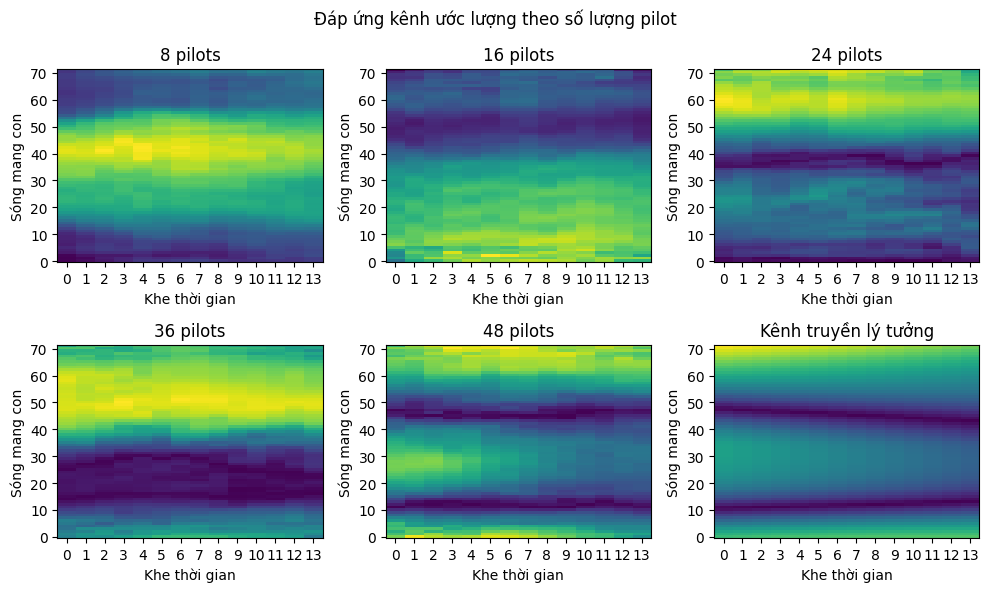

In [79]:
channel_model  = "VehA"
snr            = 12
n_samples      = 10000
n_subs         = 72
n_slots        = 14

fig, axes = plt.subplots(2, 3)
fig.set_size_inches(10, 6)
fig.suptitle('Đáp ứng kênh ước lượng theo số lượng pilot')

n_pilots_list = [8, 16, 24, 36, 48]
ax_id_list = [(0,0), (0,1), (0,2), (1,0), (1,1)]

for (n_pilots, ax_id) in zip(n_pilots_list, ax_id_list):
    path = "data/Validation_%s_%d_%d_%d.mat" % (channel_model, n_pilots, snr, n_samples)
    val_data = loadmat(path)['val_data']
    val_label = loadmat(path)['val_label']
    val_pred = models.SRCNN_predict(val_data, channel_model, n_pilots, snr, n_samples)

    pred_response = np.abs(val_pred[0].squeeze())
    axes[ax_id].imshow(pred_response, aspect='auto', origin='lower', interpolation='none')
    axes[ax_id].set_title("%d pilots" % n_pilots)

    axes[ax_id].set_ylabel('Sóng mang con')
    axes[ax_id].set_xlabel('Khe thời gian')
    axes[ax_id].set_xticks(np.arange(0, n_slots, step=1))
    axes[ax_id].set_yticks(np.arange(0, n_subs, step=10))

perfect_response = np.abs(val_label[0].squeeze())
axes[1,2].imshow(perfect_response, aspect='auto', origin='lower', interpolation='none')
axes[1,2].set_title('Kênh truyền lý tưởng')

axes[1,2].set_ylabel('Sóng mang con')
axes[1,2].set_xlabel('Khe thời gian')
axes[1,2].set_xticks(np.arange(0, n_slots, step=1))
axes[1,2].set_yticks(np.arange(0, n_subs, step=10))

plt.tight_layout()
plt.show()

In [80]:
import models, importlib
importlib.reload(models)

channel_model  = "VehA"
snr            = 12
n_samples      = 10000
n_subs         = 72
n_slots        = 14

perf_n_pilots   = []
perf_mse        = []

# for n_pilots in [8]:
for n_pilots in [8, 16, 24, 36, 48]:
    path = "data/Validation_%s_%d_%d_%d.mat" % (channel_model, n_pilots, snr, n_samples)
    val_data = loadmat(path)['val_data']
    val_label = loadmat(path)['val_label']

    val_pred = models.SRCNN_predict(val_data, channel_model, n_pilots, snr, n_samples)
    mse = np.mean((val_pred - val_label)**2)
    mse_dB = 10*np.log10(mse)

    perf_n_pilots.append(n_pilots)
    perf_mse.append(mse_dB)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


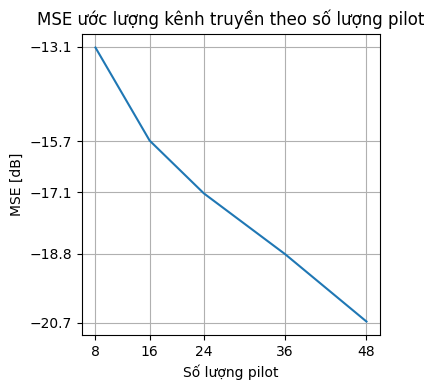

In [81]:
fig, ax = plt.subplots(figsize=(4,4))

ax.plot(perf_n_pilots, perf_mse)
ax.set_title('MSE ước lượng kênh truyền theo số lượng pilot')
ax.set_xticks(perf_n_pilots)
ax.set_yticks(np.round(perf_mse, 1))
ax.set_xlabel('Số lượng pilot')
ax.set_ylabel('MSE [dB]')
ax.grid()

plt.tight_layout()
plt.show()